The dataset(CSV) used here is downloaded from [here](https://github.com/sir-lab/data-release/blob/main/README_data_release_2023.md).

### Dataset Analysis



Each CSV represents day level number of funciton invocations for 5093 functions in Huwaie Cloud

*   Column named from '0' to '5092' represents 5093 functions
*   Each row represents the timestamp (granulairty is MINUTES) at which number of invocations were recorded.




In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

In [21]:
# Reading the dataset
file_path = "day_01.csv"
df = pd.read_csv(file_path)


Transformations done:


*   Converted the UNIX EPOCH TIME to UTC , setting ref. date to 2023-11-01
*   Filled the missing values (NaNs) to zero 0.
*   Aggregrated all values (sum) across columns named from 0 to 5092





In [22]:
# Set reference start date (01 Nov 2023)
start_date = pd.Timestamp("2023-11-01 00:00:00")

# Convert 'time' column to proper datetime format using the new reference point
df['datetime'] = start_date + pd.to_timedelta(df['time'], unit='s')

# Handle missing values (filling NaNs with 0)
df = df.fillna(0)

# Identify function invocation columns and sum them
function_columns = df.columns.difference(['day', 'time', 'datetime'])
df['total_invocations'] = df[function_columns].sum(axis=1).astype(int)  # Convert to integer

# Retain only relevant columns
df = df[['datetime', 'total_invocations']]

df.head()

,datetime,total_invocations
0,2023-11-02 00:00:00,50346
1,2023-11-02 00:01:00,46268
2,2023-11-02 00:02:00,42217
3,2023-11-02 00:03:00,38404
4,2023-11-02 00:04:00,36797


YOU NEED TO DO SOME TRANSFORMATION LIKE SCALING

### Loading the cleaned dataset

### Time Series Plots

In [23]:
df.columns

Index(['datetime', 'total_invocations'], dtype='object')

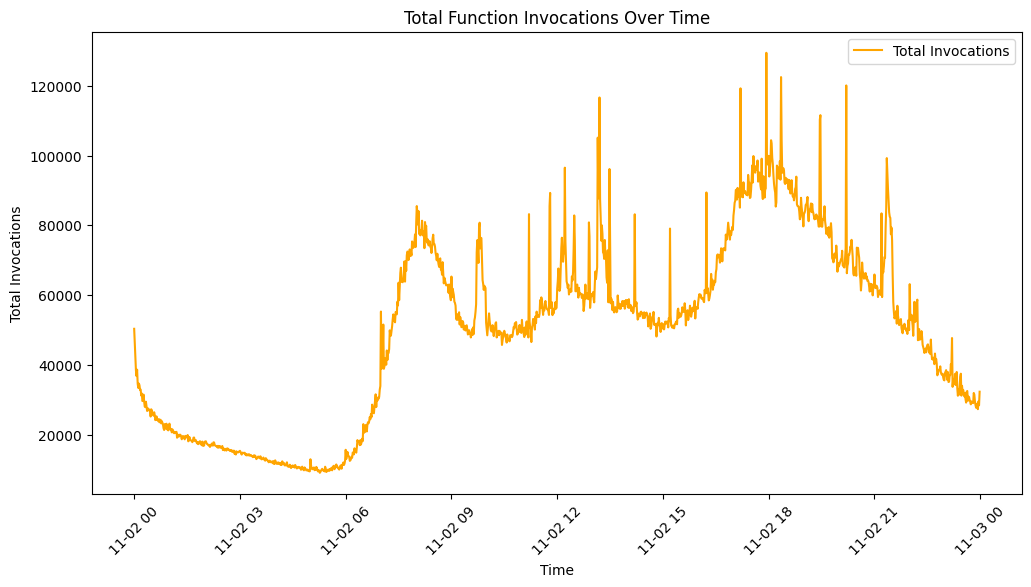

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['total_invocations'], label="Total Invocations", color='orange')
plt.xlabel("Time")
plt.ylabel("Total Invocations")
plt.title("Total Function Invocations Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Naive Baseline Model

In [25]:
# Ensure time is the index
df.set_index('datetime', inplace=True)

# Train-Test Split (80% Train, 20% Test)
train_size = int(len(df) * 0.8)  # 80% data for training
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [26]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

### Naive Baseline Model

In [27]:
naive_forecast = train['total_invocations'].iloc[-1]  # Last observed value
naive_forecast_series = np.full(len(test), naive_forecast)

### Simple Exponential Smoothing

In [28]:
ses_model = SimpleExpSmoothing(train['total_invocations']).fit(smoothing_level=0.2, optimized=True) #  smoothing parameter, alpha set to 0.2

# Forecast for test period
ses_forecast = ses_model.forecast(len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


### Holt’s Linear Trend Model

In [29]:
# Train Holt’s Linear Model
holt_model = Holt(train['total_invocations']).fit()

# Forecast
holt_forecast = holt_model.forecast(len(test))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


### Holt-Winters (Triple Exponential Smoothing)

Holt's Linear Trend Model captures both trend and sasonality, you can see in the argument trend = 'add' and seasonal = 'add', and the seasonal periods = 288 only because in training dataset we have only 1152 , (0.8 x 1440)

In [30]:
# Train Holt-Winters Model
hw_model = ExponentialSmoothing(train['total_invocations'], trend='add', seasonal='add', seasonal_periods=288).fit()

# Forecast
hw_forecast = hw_model.forecast(len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


you can see above that Holt's Winters Model doesn't perform well because it also tries to capture the seasonality and since our data doesn't have seasonality, it performs poor.

### ARIMA (AutoRegressive Integerated Moving Average)

In [31]:
# Train ARIMA Model
arima_model = ARIMA(train['total_invocations'], order=(3,1,3)).fit()  # Adjust (p,d,q) based on ACF/PACF

# Forecast
arima_forecast = arima_model.forecast(len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


### SARIMA Model

In [32]:
# Train SARIMA Model
sarima_model = SARIMAX(train['total_invocations'], order=(1,1,1), seasonal_order=(1,1,1,32)).fit()

# Forecast
sarima_forecast = sarima_model.forecast(len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


### Didn't use the VAR model since my dataset is Univariate inlcuding timestamp and total_invocations only.

### Functions that give you all the required performance metrics, MAE, RMSE, and MAPE

In [33]:
# Function to compute evaluation metrics
def evaluate_forecast(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))  # Root Mean Squared Error
    mape = np.mean(np.abs((y_true - y_pred) / (y_true+1))) * 100  # Mean Absolute Percentage Error

    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

### All Models Results

In [34]:
model_results = {}

In [35]:
model_results["Naïve Baseline"] = evaluate_forecast(test['total_invocations'], naive_forecast_series) #Naive Forecast
model_results["SES"] = evaluate_forecast(test['total_invocations'], ses_forecast) # SES
model_results["holts_linear"] = evaluate_forecast(test['total_invocations'], holt_forecast) # Holt Linear Trend
model_results["holt_winters"] = evaluate_forecast(test['total_invocations'], hw_forecast) #Holt Winter
model_results["ARIMA"] = evaluate_forecast(test['total_invocations'], arima_forecast) # ARIMA
model_results["SARIMA"] = evaluate_forecast(test['total_invocations'], sarima_forecast) # SARIMA

In [36]:
results_df = pd.DataFrame(model_results).T

from IPython.display import display
display(results_df)

,MAE,RMSE,MAPE
Naïve Baseline,28902.961806,33548.195853,68.068222
SES,28343.992142,33043.683275,66.926727
holts_linear,12028.091339,13958.850131,27.194889
holt_winters,22652.880306,28146.379508,53.612984
ARIMA,28439.136623,33129.546834,67.121268
SARIMA,38542.164498,44655.534217,90.797730
